# Análisis de Regresión

In [1]:
import numpy as np
import pandas as pd

# Graficación
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, r2_score

# Import metrics.
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option('display.float_format', lambda x: "{:,.2f}".format(x))
sns.set_theme(style="ticks")

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Funciones relevantes

In [4]:
def normalize_content(texto):
    if texto in ['G', 'TV-G']:
        return "Publico General"
    if texto in ['R', 'NC-17', 'X']:
        return "Restricted"
    if texto in ['M', 'PG', 'GP', 'PG-13','TV-PG','TV-14'] :
        return "Parental Guiadance"
    if texto in ['Approved', 'Passed']:
        return "Approved"
    if texto in ['Not Rated', 'Unrated']:
        return "Not Rated"

In [5]:
def plot_histogram(df, feature):
    return df[[feature]].iplot(kind="hist", title = f"{feature} histogram", colors=["#296EAA"])

## Carga de datos

In [6]:
df = pd.read_csv('/Users/gblasd/Documents/DataScience/02_SupervisedLearning/data/movies/movies.csv')
df = pd.read_csv('/Users/gblasd/Documents/DataScience/02_SupervisedLearning/data/movies/movies.csv')

In [7]:
df.shape

(5043, 16)

In [8]:
df.sample(5)

,movie_title,movie_imdb_link,color,genre_4,duration,gross,genre_1,genre_2,genre_3,num_voted_users,facenumber_in_poster,language,country,content_rating,title_year,imdb_score
2355,The Nutcracker,http://www.imdb.com/title/tt0107719/?ref_=fn_t...,Color,NaN,92.00,"2,119,994.00",Family,Fantasy,Music,1153,0,English,USA,G,"1,993.00",5.70
354,In the Company of Men,http://www.imdb.com/title/tt0119361/?ref_=fn_t...,Color,NaN,97.00,NaN,Comedy,Drama,NaN,11550,0,English,Canada,R,"1,997.00",7.30
2087,20 Feet from Stardom,http://www.imdb.com/title/tt2396566/?ref_=fn_t...,Color,NaN,91.00,"4,946,250.00",Documentary,Music,NaN,9540,0,English,USA,PG-13,"2,013.00",7.40
606,xXx: State of the Union,http://www.imdb.com/title/tt0329774/?ref_=fn_t...,Color,Thriller,101.00,"26,082,914.00",Action,Adventure,Crime,51349,2,English,USA,PG-13,"2,005.00",4.30
1866,Family Plot,http://www.imdb.com/title/tt0074512/?ref_=fn_t...,Color,NaN,120.00,NaN,Comedy,Thriller,NaN,15293,1,English,USA,PG,"1,976.00",6.80


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           5043 non-null   object 
 1   movie_imdb_link       5043 non-null   object 
 2   color                 5024 non-null   object 
 3   genre_4               1427 non-null   object 
 4   duration              5028 non-null   float64
 5   gross                 1505 non-null   float64
 6   genre_1               5043 non-null   object 
 7   genre_2               4410 non-null   object 
 8   genre_3               3055 non-null   object 
 9   num_voted_users       5043 non-null   object 
 10  facenumber_in_poster  5031 non-null   object 
 11  language              5029 non-null   object 
 12  country               5038 non-null   object 
 13  content_rating        4741 non-null   object 
 14  title_year            4935 non-null   float64
 15  imdb_score           

## Análisis exploratorio

In [10]:
# Discretas
ls_disc = ["color", "genre_4", "genre_1", "genre_2", "genre_3", "language", "country", "content_rating"]
# Continuas
ls_cont = ["duration", "gross", "num_voted_users", "facenumber_in_poster", "title_year"]
# Target
target = "imdb_score"

In [11]:
df[ls_cont+[target]].head()

,duration,gross,num_voted_users,facenumber_in_poster,title_year,imdb_score
0,114.00,NaN,28584,1,"2,002.00",6.30
1,108.00,NaN,24033,3,"2,005.00",7.00
2,96.00,NaN,7528,0,"1,984.00",5.50
3,100.00,"21,520,719.00",10103,1,"2,010.00",5.80
4,132.00,"30,400,000.00",9503,1,"1,983.00",6.60


<Axes: xlabel='imdb_score', ylabel='Count'>

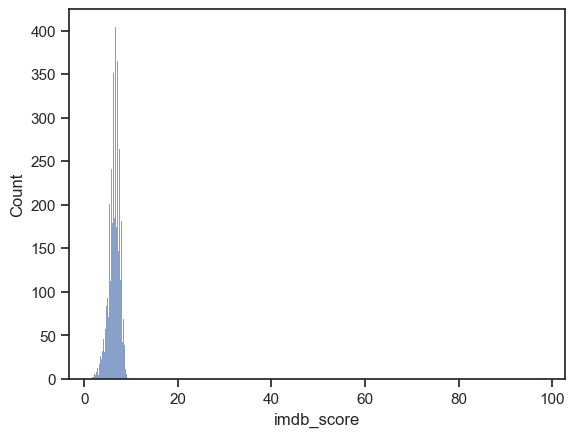

In [12]:
sns.histplot(df[target])

In [13]:
df[ls_cont+[target]].describe(percentiles= [0.01, 0.25, 0.5, 0.75, 0.99])

,duration,gross,title_year,imdb_score
count,"5,028.00","1,505.00","4,935.00","5,043.00"
mean,107.20,"47,523,599.37","2,042.59",6.46
std,25.20,"70,034,507.15","2,818.52",1.71
min,7.00,721.00,"1,916.00",1.60
1%,43.00,"5,012.76","1,951.34",3.10
25%,93.00,"5,018,450.00","1,999.00",5.80
50%,103.00,"24,792,061.00","2,005.00",6.60
75%,118.00,"60,154,431.00","2,011.00",7.20
99%,189.00,"336,530,303.00","2,016.00",8.50
max,511.00,"760,505,847.00","200,000.00",98.00


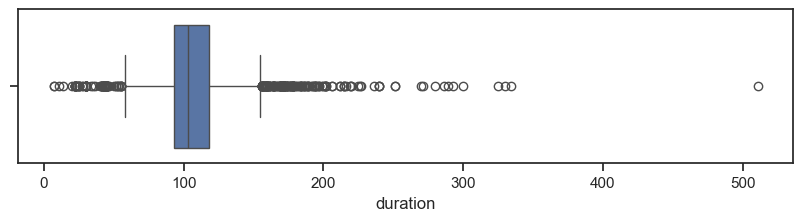

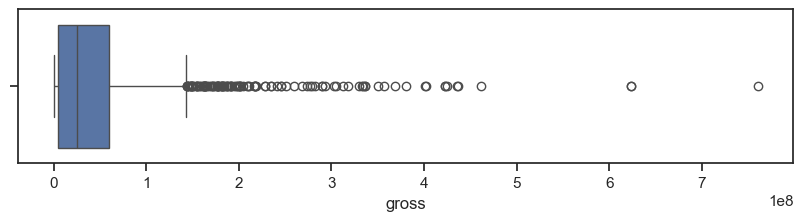

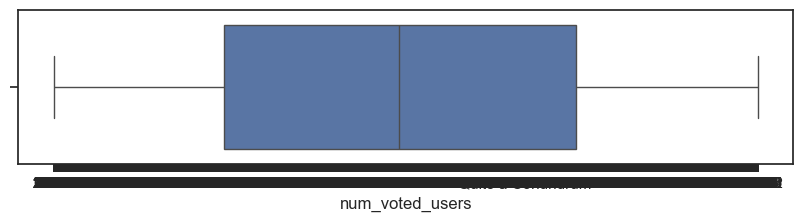

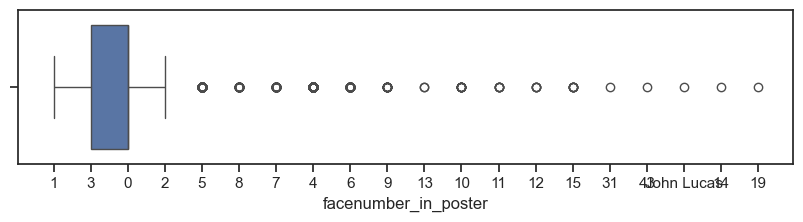

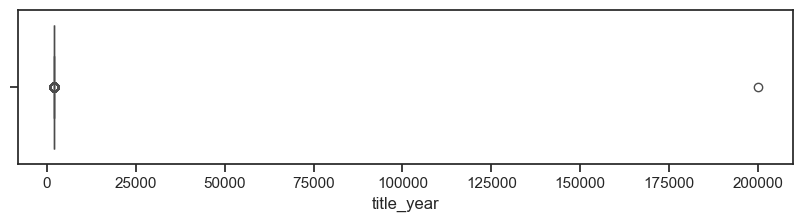

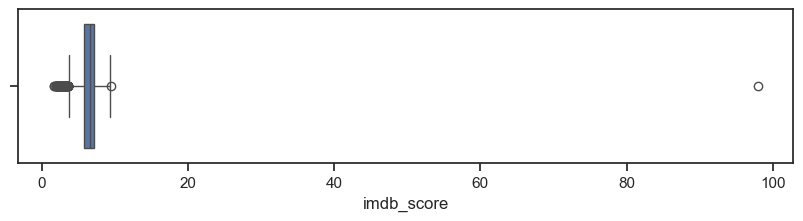

In [14]:
for col in ls_cont+[target]:
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df[col], width=0.8)

In [15]:
df[df['gross'] >= df['gross'].describe(percentiles=[.99]).T['99%']].sample(5)

,movie_title,movie_imdb_link,color,genre_4,duration,gross,genre_1,genre_2,genre_3,num_voted_users,facenumber_in_poster,language,country,content_rating,title_year,imdb_score
2348,Transformers: Revenge of the Fallen,http://www.imdb.com/title/tt1055369/?ref_=fn_t...,Color,NaN,150.00,"402,076,689.00",Action,Adventure,Sci-Fi,323207,0,English,USA,PG-13,"2,009.00",6.00
4683,Frozen,http://www.imdb.com/title/tt2294629/?ref_=fn_t...,Color,Family,102.00,"400,736,600.00",Adventure,Animation,Comedy,421658,0,English,USA,PG,"2,013.00",7.60
2521,Star Wars: Episode IV - A New Hope,http://www.imdb.com/title/tt0076759/?ref_=fn_t...,Color,Sci-Fi,125.00,"460,935,665.00",Action,Adventure,Fantasy,911097,1,English,USA,PG,"1,977.00",8.70
4885,Spider-Man 3,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,Color,NaN,156.00,"336,530,303.00",Action,Adventure,Romance,383071,0,English,USA,PG-13,"2,007.00",6.20
156,The Hunger Games: Catching Fire,http://www.imdb.com/title/tt1951264/?ref_=fn_t...,Color,NaN,146.00,"424,645,577.00",Adventure,Sci-Fi,Thriller,498397,1,English,USA,PG-13,"2,013.00",7.60


In [16]:
df['imdb_score'].sort_values().tail()

3385    9.10
4426    9.20
4305    9.30
3997    9.50
3319   98.00
Name: imdb_score, dtype: float64

In [17]:
df = df[df[target] != 98].reset_index(drop = True)

In [18]:
df["num_voted_users"] = df["num_voted_users"].astype(float)
df["facenumber_in_poster"] = df["facenumber_in_poster"].astype(float)

In [19]:
df[ls_cont+[target]].describe(percentiles= [0.01, 0.25, 0.5, 0.75, 0.99])

,duration,gross,num_voted_users,facenumber_in_poster,title_year,imdb_score
count,"5,027.00","1,505.00","5,042.00","5,030.00","4,934.00","5,042.00"
mean,107.21,"47,523,599.37","83,684.73",1.37,"2,002.47",6.44
std,25.20,"70,034,507.15","138,493.99",2.01,12.48,1.13
min,7.00,721.00,5.00,0.00,"1,916.00",1.60
1%,43.00,"5,012.76",54.23,0.00,"1,951.33",3.10
25%,93.00,"5,018,450.00","8,599.25",0.00,"1,999.00",5.80
50%,103.00,"24,792,061.00","34,371.00",1.00,"2,005.00",6.60
75%,118.00,"60,154,431.00","96,347.00",2.00,"2,011.00",7.20
99%,189.00,"336,530,303.00","681,112.44",8.00,"2,016.00",8.50
max,511.00,"760,505,847.00","1,689,764.00",43.00,"2,016.00",9.50


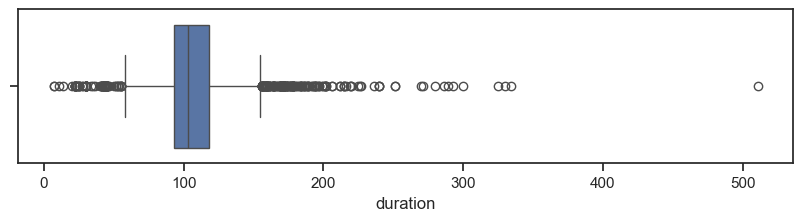

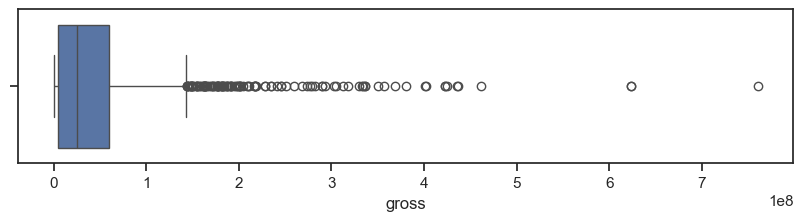

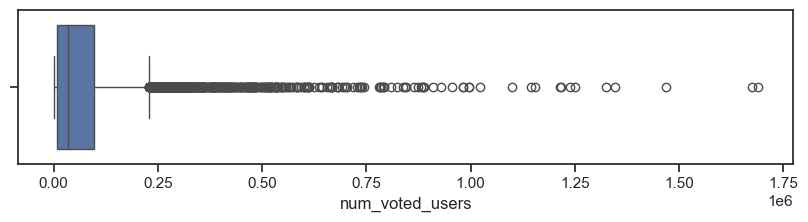

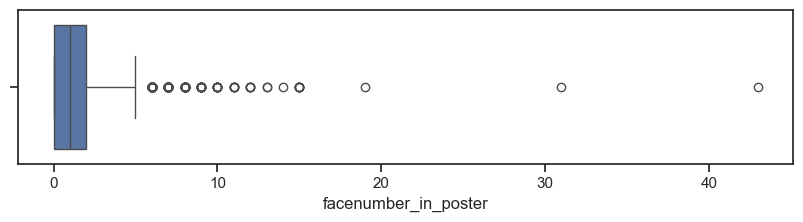

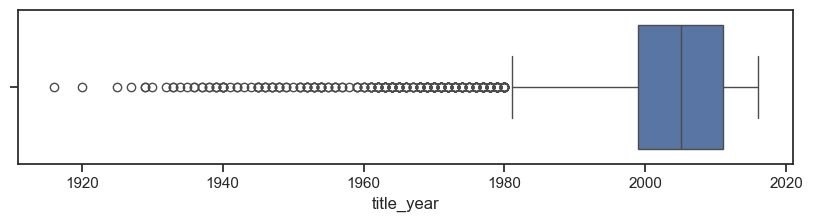

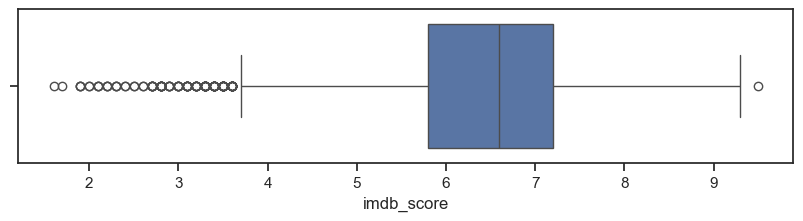

In [20]:
for col in ls_cont+[target]:
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=df[col], width=0.8)

### Variables continuas

In [21]:
df[ls_cont+[target]].describe(percentiles = [0.1, 0.5, 0.95, 0.99])

,duration,gross,num_voted_users,facenumber_in_poster,title_year,imdb_score
count,"5,027.00","1,505.00","5,042.00","5,030.00","4,934.00","5,042.00"
mean,107.21,"47,523,599.37","83,684.73",1.37,"2,002.47",6.44
std,25.20,"70,034,507.15","138,493.99",2.01,12.48,1.13
min,7.00,721.00,5.00,0.00,"1,916.00",1.60
10%,86.00,"335,377.20","1,649.70",0.00,"1,988.00",5.00
50%,103.00,"24,792,061.00","34,371.00",1.00,"2,005.00",6.60
95%,146.00,"177,159,421.40","332,265.45",5.00,"2,015.00",8.09
99%,189.00,"336,530,303.00","681,112.44",8.00,"2,016.00",8.50
max,511.00,"760,505,847.00","1,689,764.00",43.00,"2,016.00",9.50


<Axes: xlabel='imdb_score', ylabel='Count'>

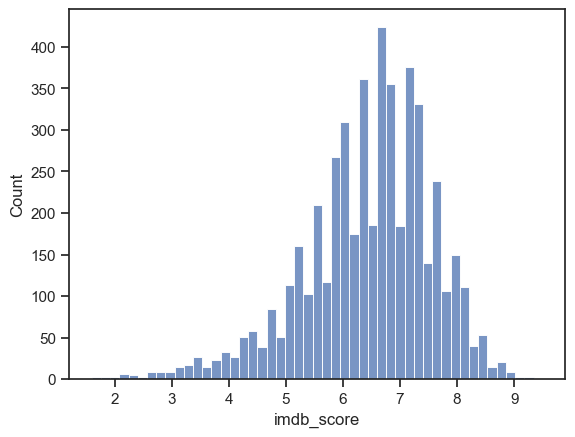

In [22]:
sns.histplot(df[target])

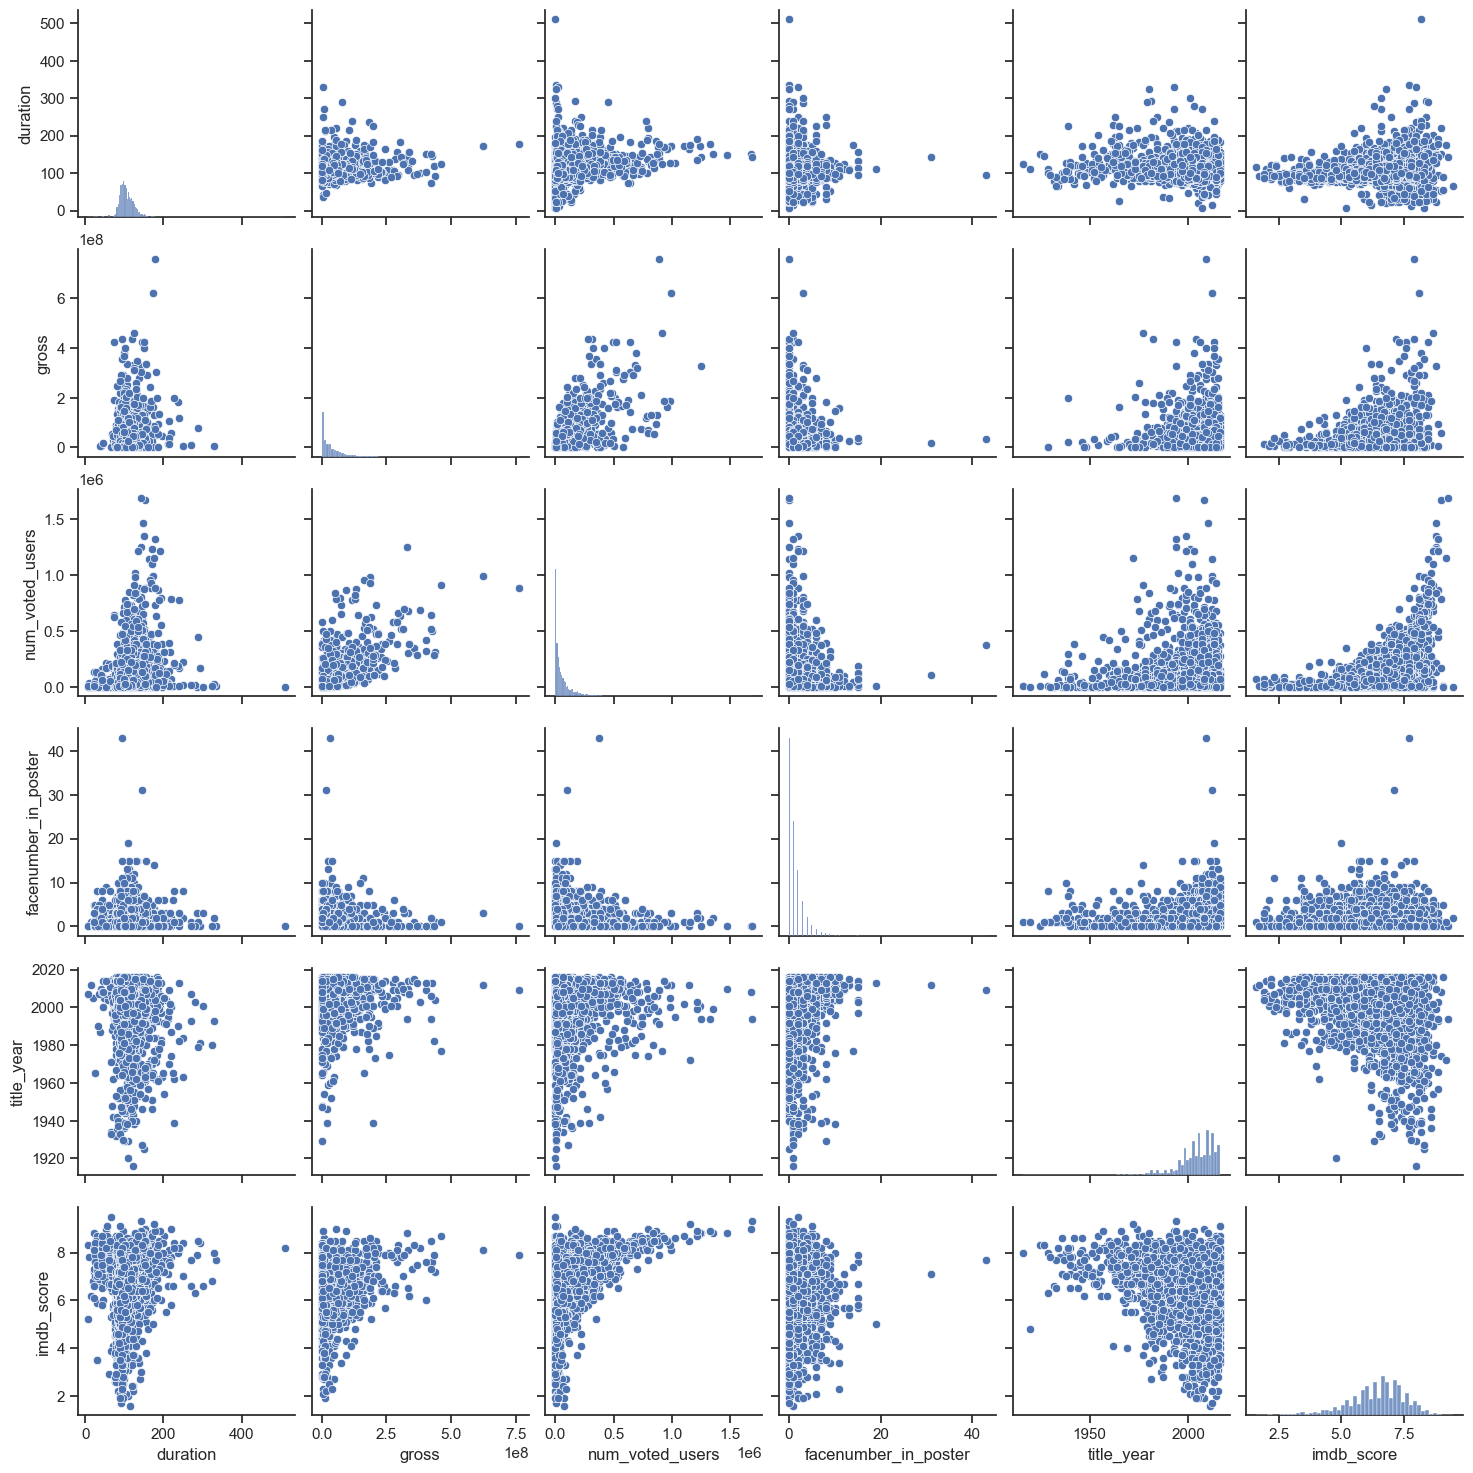

In [23]:
sns.pairplot(df[ls_cont+[target]])

### Variables discretas

In [24]:
df[ls_disc].describe()

,color,genre_4,genre_1,genre_2,genre_3,language,country,content_rating
count,5023,1427,5042,4409,3054,5028,5037,4740
unique,2,17,21,24,23,46,65,18
top,Color,Thriller,Comedy,Drama,Thriller,English,USA,R
freq,4814,481,1328,1204,538,4703,3806,2118


Proporcion de los elementos de cada variable categorica

In [25]:
#for col in ls_disc:
#    display(df[col].value_counts(True).reset_index())

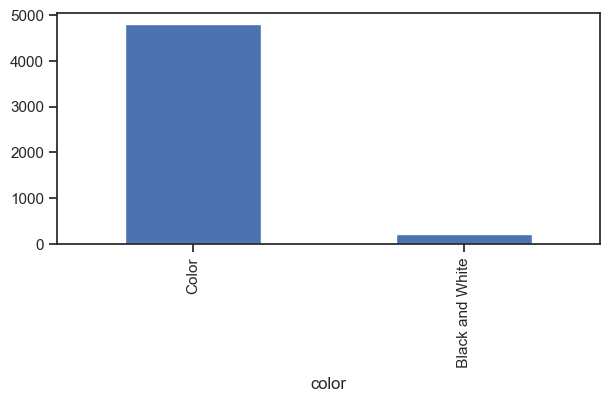

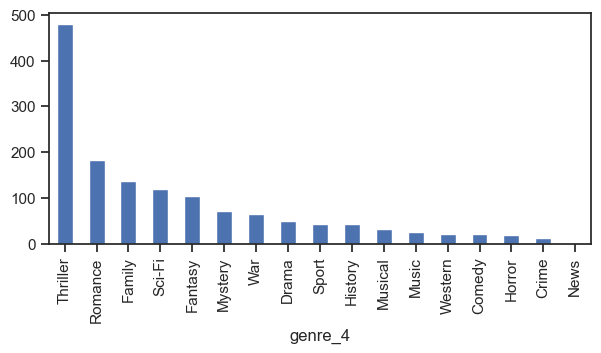

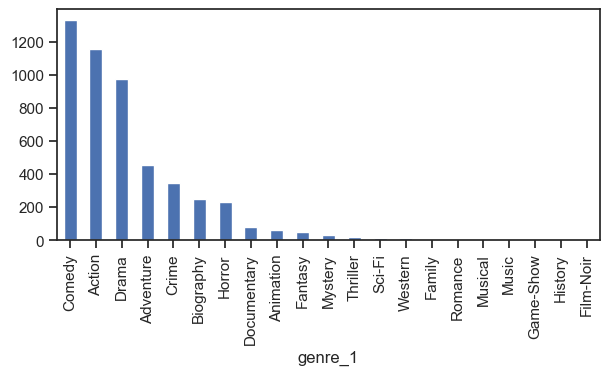

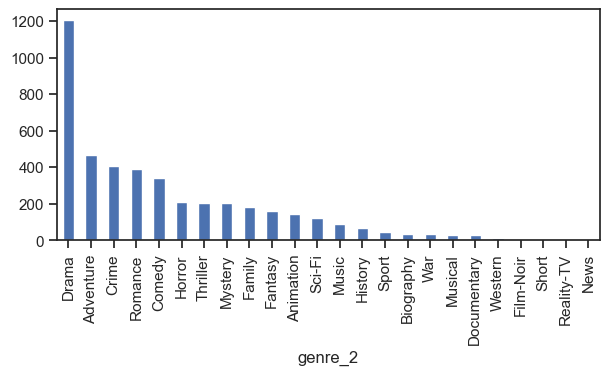

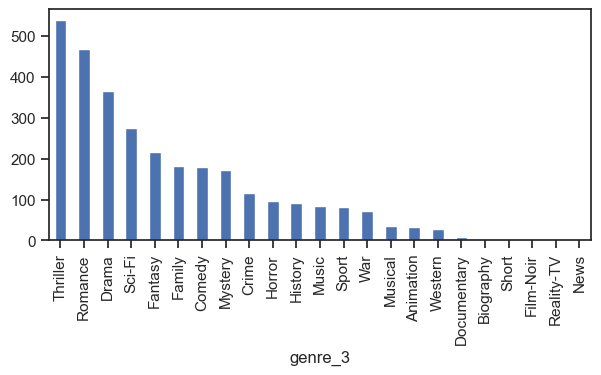

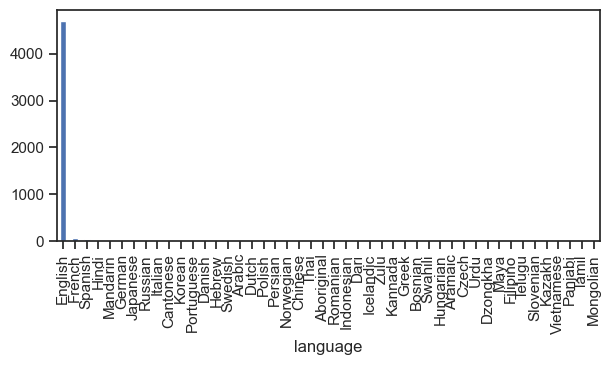

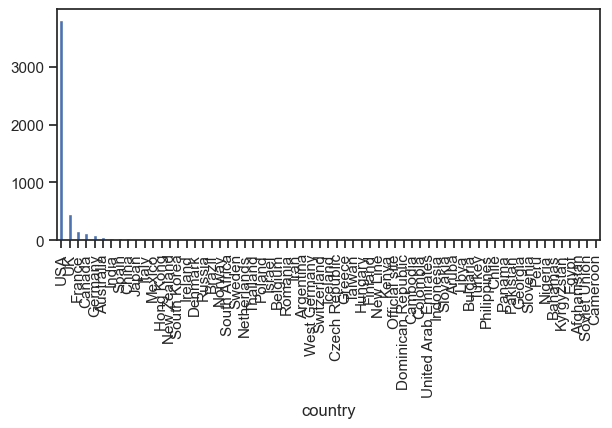

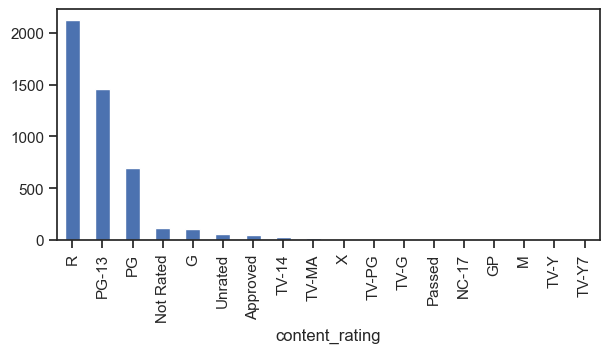

In [26]:
for x in ls_disc:
    plt.figure(figsize=(7, 3))
    df[x].value_counts().plot(kind='bar')
    plt.show()

In [27]:
def freq(df, var):
    if type(var) != list:
        var = [var]
    for v in var:
        #v = 'state'
        aux = df[v].value_counts().to_frame().rename(columns={'count':'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(  np.cumsum )
        print(f"La variable: {v}")
        display(aux)
        print("\n")

In [28]:
freq(df, var=ls_disc)

La variable: color


,FA,FR,FAA,FRA
color,,,,
Color,4814,0.96,4814,0.96
Black and White,209,0.04,5023,1.00




La variable: genre_4


,FA,FR,FAA,FRA
genre_4,,,,
Thriller,481,0.34,481,0.34
Romance,182,0.13,663,0.46
Family,136,0.10,799,0.56
Sci-Fi,120,0.08,919,0.64
Fantasy,104,0.07,1023,0.72
Mystery,71,0.05,1094,0.77
War,64,0.04,1158,0.81
Drama,50,0.04,1208,0.85
Sport,44,0.03,1252,0.88




La variable: genre_1


,FA,FR,FAA,FRA
genre_1,,,,
Comedy,1328,0.26,1328,0.26
Action,1153,0.23,2481,0.49
Drama,972,0.19,3453,0.68
Adventure,453,0.09,3906,0.77
Crime,349,0.07,4255,0.84
Biography,252,0.05,4507,0.89
Horror,232,0.05,4739,0.94
Documentary,84,0.02,4823,0.96
Animation,61,0.01,4884,0.97




La variable: genre_2


,FA,FR,FAA,FRA
genre_2,,,,
Drama,1204,0.27,1204,0.27
Adventure,470,0.11,1674,0.38
Crime,410,0.09,2084,0.47
Romance,390,0.09,2474,0.56
Comedy,341,0.08,2815,0.64
Horror,213,0.05,3028,0.69
Thriller,207,0.05,3235,0.73
Mystery,205,0.05,3440,0.78
Family,181,0.04,3621,0.82




La variable: genre_3


,FA,FR,FAA,FRA
genre_3,,,,
Thriller,538,0.18,538,0.18
Romance,468,0.15,1006,0.33
Drama,365,0.12,1371,0.45
Sci-Fi,275,0.09,1646,0.54
Fantasy,216,0.07,1862,0.61
Family,183,0.06,2045,0.67
Comedy,180,0.06,2225,0.73
Mystery,172,0.06,2397,0.78
Crime,116,0.04,2513,0.82




La variable: language


,FA,FR,FAA,FRA
language,,,,
English,4703,0.94,4703,0.94
French,73,0.01,4776,0.95
Spanish,40,0.01,4816,0.96
Hindi,28,0.01,4844,0.96
Mandarin,26,0.01,4870,0.97
German,19,0.00,4889,0.97
Japanese,18,0.00,4907,0.98
Russian,11,0.00,4918,0.98
Italian,11,0.00,4929,0.98




La variable: country


,FA,FR,FAA,FRA
country,,,,
USA,3806,0.76,3806,0.76
UK,448,0.09,4254,0.84
France,154,0.03,4408,0.88
Canada,126,0.03,4534,0.90
Germany,97,0.02,4631,0.92
...,...,...,...,...
Kyrgyzstan,1,0.00,5033,1.00
Egypt,1,0.00,5034,1.00
Afghanistan,1,0.00,5035,1.00




La variable: content_rating


,FA,FR,FAA,FRA
content_rating,,,,
R,2118,0.45,2118,0.45
PG-13,1461,0.31,3579,0.76
PG,701,0.15,4280,0.90
Not Rated,116,0.02,4396,0.93
G,112,0.02,4508,0.95
Unrated,62,0.01,4570,0.96
Approved,55,0.01,4625,0.98
TV-14,30,0.01,4655,0.98
TV-MA,20,0.00,4675,0.99


#### Normalizar

In [29]:
def normalizar(df, v, umbral):
    #umbral = 0.03 # 0.05
    aux = df[v].value_counts(True).to_frame()
    aux[f"n__{v}"] = np.where( aux['proportion'] < umbral , 'CAT_PEQUE' ,aux.index )
    
    moda  = aux.head()[f'n__{v}'].values[0]
    
    if aux.loc[ aux[f'n__{v}'] == 'CAT_PEQUE' ]['proportion'].sum() < umbral:
        aux[f'n__{v}'].replace({'CAT_PEQUE':moda},inplace=True)
    
    aux.reset_index(inplace=True)

    return df.merge( aux , left_on=[v] , right_on=[v] , how='inner' ).drop('proportion',axis=1)

In [30]:
umbral = 0.05
for v in ls_disc:
    print(f"Normalizando: {v}")
    df =  normalizar( df , v, umbral)

Normalizando: color
Normalizando: genre_4
Normalizando: genre_1
Normalizando: genre_2
Normalizando: genre_3
Normalizando: language
Normalizando: country
Normalizando: content_rating


In [31]:
ls_disc = df.filter( like='n__' ).columns.tolist()
ls_disc

['n__color',
 'n__genre_4',
 'n__genre_1',
 'n__genre_2',
 'n__genre_3',
 'n__language',
 'n__country',
 'n__content_rating']

In [32]:
freq( df, ls_disc)

La variable: n__color


,FA,FR,FAA,FRA
n__color,,,,
Color,1368,1.00,1368,1.00




La variable: n__genre_4


,FA,FR,FAA,FRA
n__genre_4,,,,
Thriller,457,0.33,457,0.33
CAT_PEQUE,391,0.29,848,0.62
Romance,173,0.13,1021,0.75
Family,133,0.10,1154,0.84
Sci-Fi,114,0.08,1268,0.93
Fantasy,100,0.07,1368,1.00




La variable: n__genre_1


,FA,FR,FAA,FRA
n__genre_1,,,,
Action,659,0.48,659,0.48
Adventure,253,0.18,912,0.67
Comedy,150,0.11,1062,0.78
Drama,122,0.09,1184,0.87
Crime,98,0.07,1282,0.94
Biography,86,0.06,1368,1.00




La variable: n__genre_2


,FA,FR,FAA,FRA
n__genre_2,,,,
Drama,309,0.23,309,0.23
Adventure,287,0.21,596,0.44
CAT_PEQUE,201,0.15,797,0.58
Crime,194,0.14,991,0.72
Comedy,179,0.13,1170,0.86
Animation,132,0.10,1302,0.95
Horror,66,0.05,1368,1.00




La variable: n__genre_3


,FA,FR,FAA,FRA
n__genre_3,,,,
Drama,275,0.20,275,0.20
CAT_PEQUE,237,0.17,512,0.37
Comedy,163,0.12,675,0.49
Family,134,0.10,809,0.59
Mystery,126,0.09,935,0.68
Sci-Fi,126,0.09,1061,0.78
Fantasy,118,0.09,1179,0.86
Romance,106,0.08,1285,0.94
Crime,83,0.06,1368,1.00




La variable: n__language


,FA,FR,FAA,FRA
n__language,,,,
English,1301,0.95,1301,0.95
CAT_PEQUE,67,0.05,1368,1.00




La variable: n__country


,FA,FR,FAA,FRA
n__country,,,,
USA,1024,0.75,1024,0.75
CAT_PEQUE,216,0.16,1240,0.91
UK,128,0.09,1368,1.00




La variable: n__content_rating


,FA,FR,FAA,FRA
n__content_rating,,,,
R,505,0.37,505,0.37
PG-13,399,0.29,904,0.66
PG,306,0.22,1210,0.88
CAT_PEQUE,82,0.06,1292,0.94
G,76,0.06,1368,1.00


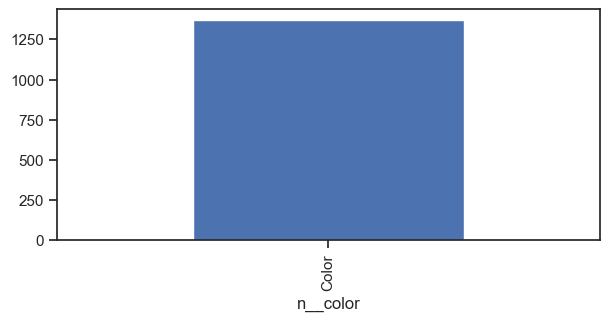

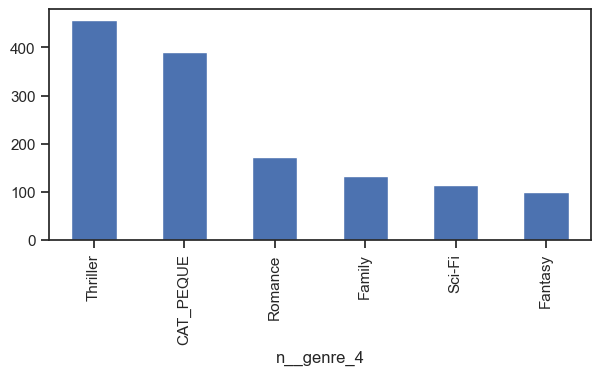

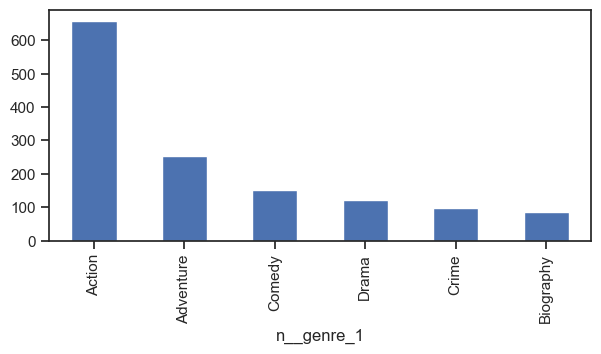

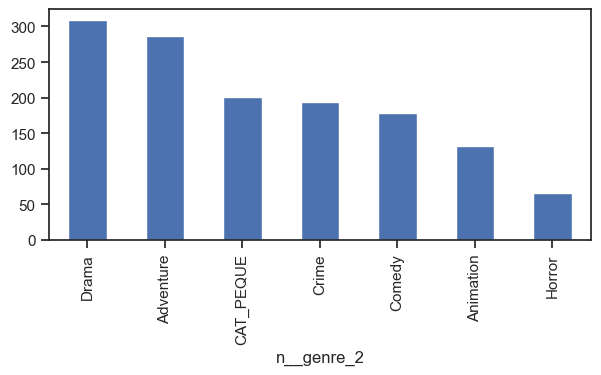

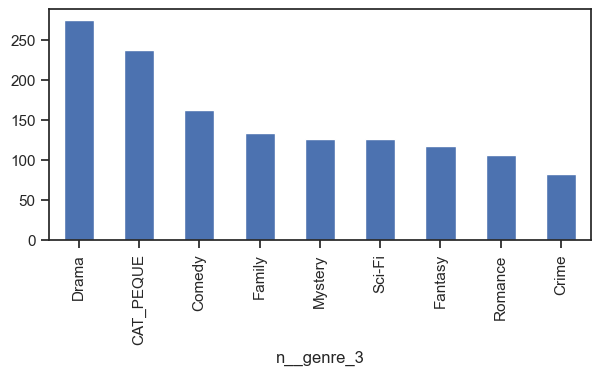

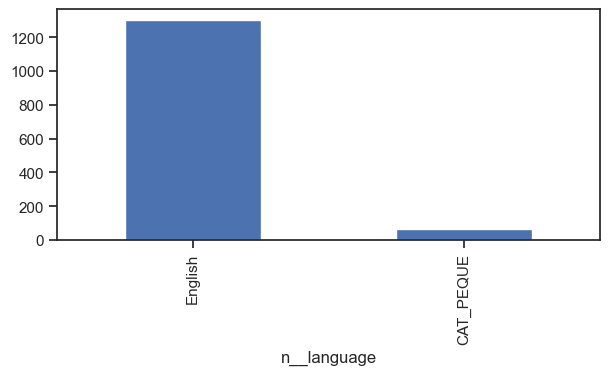

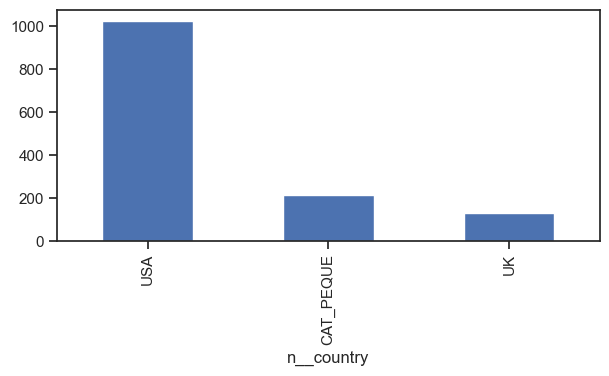

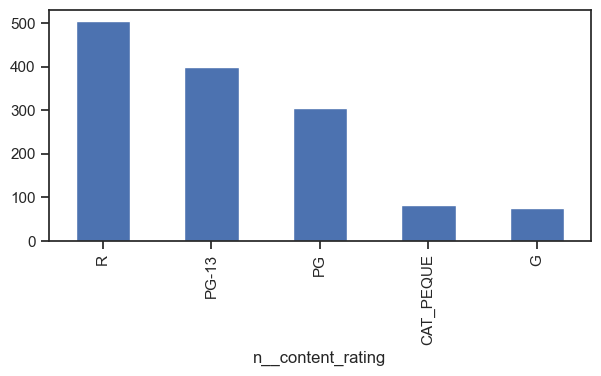

In [33]:
for x in ls_disc:
    plt.figure(figsize=(7, 3))
    df[x].value_counts().plot(kind='bar')
    plt.show()

#### unarias

In [34]:
# ariable categoricas que solo tienen una "categoria" o un valor unico
unarias = [v for v, cont in zip( ls_disc, [ df[v].unique().shape[0] for v in ls_disc ] ) if cont == 1]
unarias

['n__color']

In [35]:
df[unarias].head(3)

,n__color
0,Color
1,Color
2,Color


In [36]:
ls_disc = [ _ for _ in ls_disc if _ not in unarias]
ls_disc

['n__genre_4',
 'n__genre_1',
 'n__genre_2',
 'n__genre_3',
 'n__language',
 'n__country',
 'n__content_rating']

Valores __NaN__ pro cada variable en el dataset:

In [37]:
df[ls_disc+ls_cont].isnull().sum() / len(df) *100

n__genre_4              0.00
n__genre_1              0.00
n__genre_2              0.00
n__genre_3              0.00
n__language             0.00
n__country              0.00
n__content_rating       0.00
duration                0.07
gross                  69.74
num_voted_users         0.00
facenumber_in_poster    0.07
title_year              1.75
dtype: float64

In [38]:
# Eliminamos los valores con mas del 30% de valores NaN 
# ls_drop = ["gross", "genre_4", "genre_3", "title_year"]
ls_drop = ["gross"]
df.drop(columns=ls_drop,inplace=True)

Se descartan las variables eliminadas de la list de variables

In [39]:
# Ajuste de valores por cada lista
ls_cont = [x for x in ls_cont if x not in ls_drop]
ls_disc = [x for x in ls_disc if x not in ls_drop]

# Se eliminan las columnas y se guarda en el df original
df = df.dropna(subset = ls_cont+ls_disc).reset_index(drop = True)

In [40]:
df.head()

,movie_title,movie_imdb_link,color,genre_4,duration,genre_1,genre_2,genre_3,num_voted_users,facenumber_in_poster,language,country,content_rating,title_year,imdb_score,n__color,n__genre_4,n__genre_1,n__genre_2,n__genre_3,n__language,n__country,n__content_rating
0,Femme Fatale,http://www.imdb.com/title/tt0280665/?ref_=fn_t...,Color,Thriller,114.00,Crime,Drama,Mystery,"28,584.00",1.00,English,France,R,"2,002.00",6.30,Color,Thriller,Crime,Drama,Mystery,English,CAT_PEQUE,R
1,The Haunting,http://www.imdb.com/title/tt0171363/?ref_=fn_t...,Color,Thriller,113.00,Fantasy,Horror,Mystery,"58,184.00",0.00,English,USA,PG-13,"1,999.00",4.90,Color,Thriller,Action,Horror,Mystery,English,USA,PG-13
2,Whiteout,http://www.imdb.com/title/tt0365929/?ref_=fn_t...,Color,Thriller,101.00,Action,Crime,Mystery,"31,918.00",1.00,English,USA,R,"2,009.00",5.50,Color,Thriller,Action,Crime,Mystery,English,USA,R
3,Griff the Invisible,http://www.imdb.com/title/tt1509803/?ref_=fn_t...,Color,Sci-Fi,90.00,Comedy,Drama,Romance,"4,173.00",1.00,English,Australia,PG-13,"2,010.00",6.10,Color,Sci-Fi,Comedy,Drama,Romance,English,CAT_PEQUE,PG-13
4,AVP: Alien vs. Predator,http://www.imdb.com/title/tt0370263/?ref_=fn_t...,Color,Thriller,109.00,Action,Horror,Sci-Fi,"143,628.00",0.00,English,USA,PG-13,"2,004.00",5.60,Color,Thriller,Action,Horror,Sci-Fi,English,USA,PG-13


In [41]:
df['n__language'].value_counts()

n__language
English      1277
CAT_PEQUE      66
Name: count, dtype: int64

In [42]:
df.shape

(1343, 23)

In [43]:
df["content_rating"] = df["content_rating"].map(normalize_content)
df.head(10)

,movie_title,movie_imdb_link,color,genre_4,duration,genre_1,genre_2,genre_3,num_voted_users,facenumber_in_poster,language,country,content_rating,title_year,imdb_score,n__color,n__genre_4,n__genre_1,n__genre_2,n__genre_3,n__language,n__country,n__content_rating
0,Femme Fatale,http://www.imdb.com/title/tt0280665/?ref_=fn_t...,Color,Thriller,114.00,Crime,Drama,Mystery,"28,584.00",1.00,English,France,Restricted,"2,002.00",6.30,Color,Thriller,Crime,Drama,Mystery,English,CAT_PEQUE,R
1,The Haunting,http://www.imdb.com/title/tt0171363/?ref_=fn_t...,Color,Thriller,113.00,Fantasy,Horror,Mystery,"58,184.00",0.00,English,USA,Parental Guiadance,"1,999.00",4.90,Color,Thriller,Action,Horror,Mystery,English,USA,PG-13
2,Whiteout,http://www.imdb.com/title/tt0365929/?ref_=fn_t...,Color,Thriller,101.00,Action,Crime,Mystery,"31,918.00",1.00,English,USA,Restricted,"2,009.00",5.50,Color,Thriller,Action,Crime,Mystery,English,USA,R
3,Griff the Invisible,http://www.imdb.com/title/tt1509803/?ref_=fn_t...,Color,Sci-Fi,90.00,Comedy,Drama,Romance,"4,173.00",1.00,English,Australia,Parental Guiadance,"2,010.00",6.10,Color,Sci-Fi,Comedy,Drama,Romance,English,CAT_PEQUE,PG-13
4,AVP: Alien vs. Predator,http://www.imdb.com/title/tt0370263/?ref_=fn_t...,Color,Thriller,109.00,Action,Horror,Sci-Fi,"143,628.00",0.00,English,USA,Parental Guiadance,"2,004.00",5.60,Color,Thriller,Action,Horror,Sci-Fi,English,USA,PG-13
5,Madagascar 3: Europe's Most Wanted,http://www.imdb.com/title/tt1277953/?ref_=fn_t...,Color,Family,93.00,Adventure,Animation,Comedy,"119,213.00",0.00,English,USA,Parental Guiadance,"2,012.00",6.90,Color,Family,Adventure,Animation,Comedy,English,USA,PG
6,Saints and Soldiers,http://www.imdb.com/title/tt0373283/?ref_=fn_t...,Color,War,90.00,Action,Adventure,Drama,"17,725.00",0.00,English,USA,Parental Guiadance,"2,003.00",6.80,Color,CAT_PEQUE,Action,Adventure,Drama,English,USA,PG-13
7,Queen of the Mountains,http://www.imdb.com/title/tt2640460/?ref_=fn_t...,Color,History,135.00,Action,Biography,Drama,"3,144.00",1.00,English,Kyrgyzstan,Parental Guiadance,"2,014.00",8.70,Color,CAT_PEQUE,Action,CAT_PEQUE,Drama,English,CAT_PEQUE,PG-13
8,The Santa Clause,http://www.imdb.com/title/tt0111070/?ref_=fn_t...,Color,Fantasy,97.00,Comedy,Drama,Family,"64,742.00",0.00,English,USA,Parental Guiadance,"1,994.00",6.40,Color,Fantasy,Comedy,Drama,Family,English,USA,PG
9,Kingdom of Heaven,http://www.imdb.com/title/tt0320661/?ref_=fn_t...,Color,History,194.00,Action,Adventure,Drama,"217,373.00",1.00,English,USA,Restricted,"2,005.00",7.20,Color,CAT_PEQUE,Action,Adventure,Drama,English,USA,R


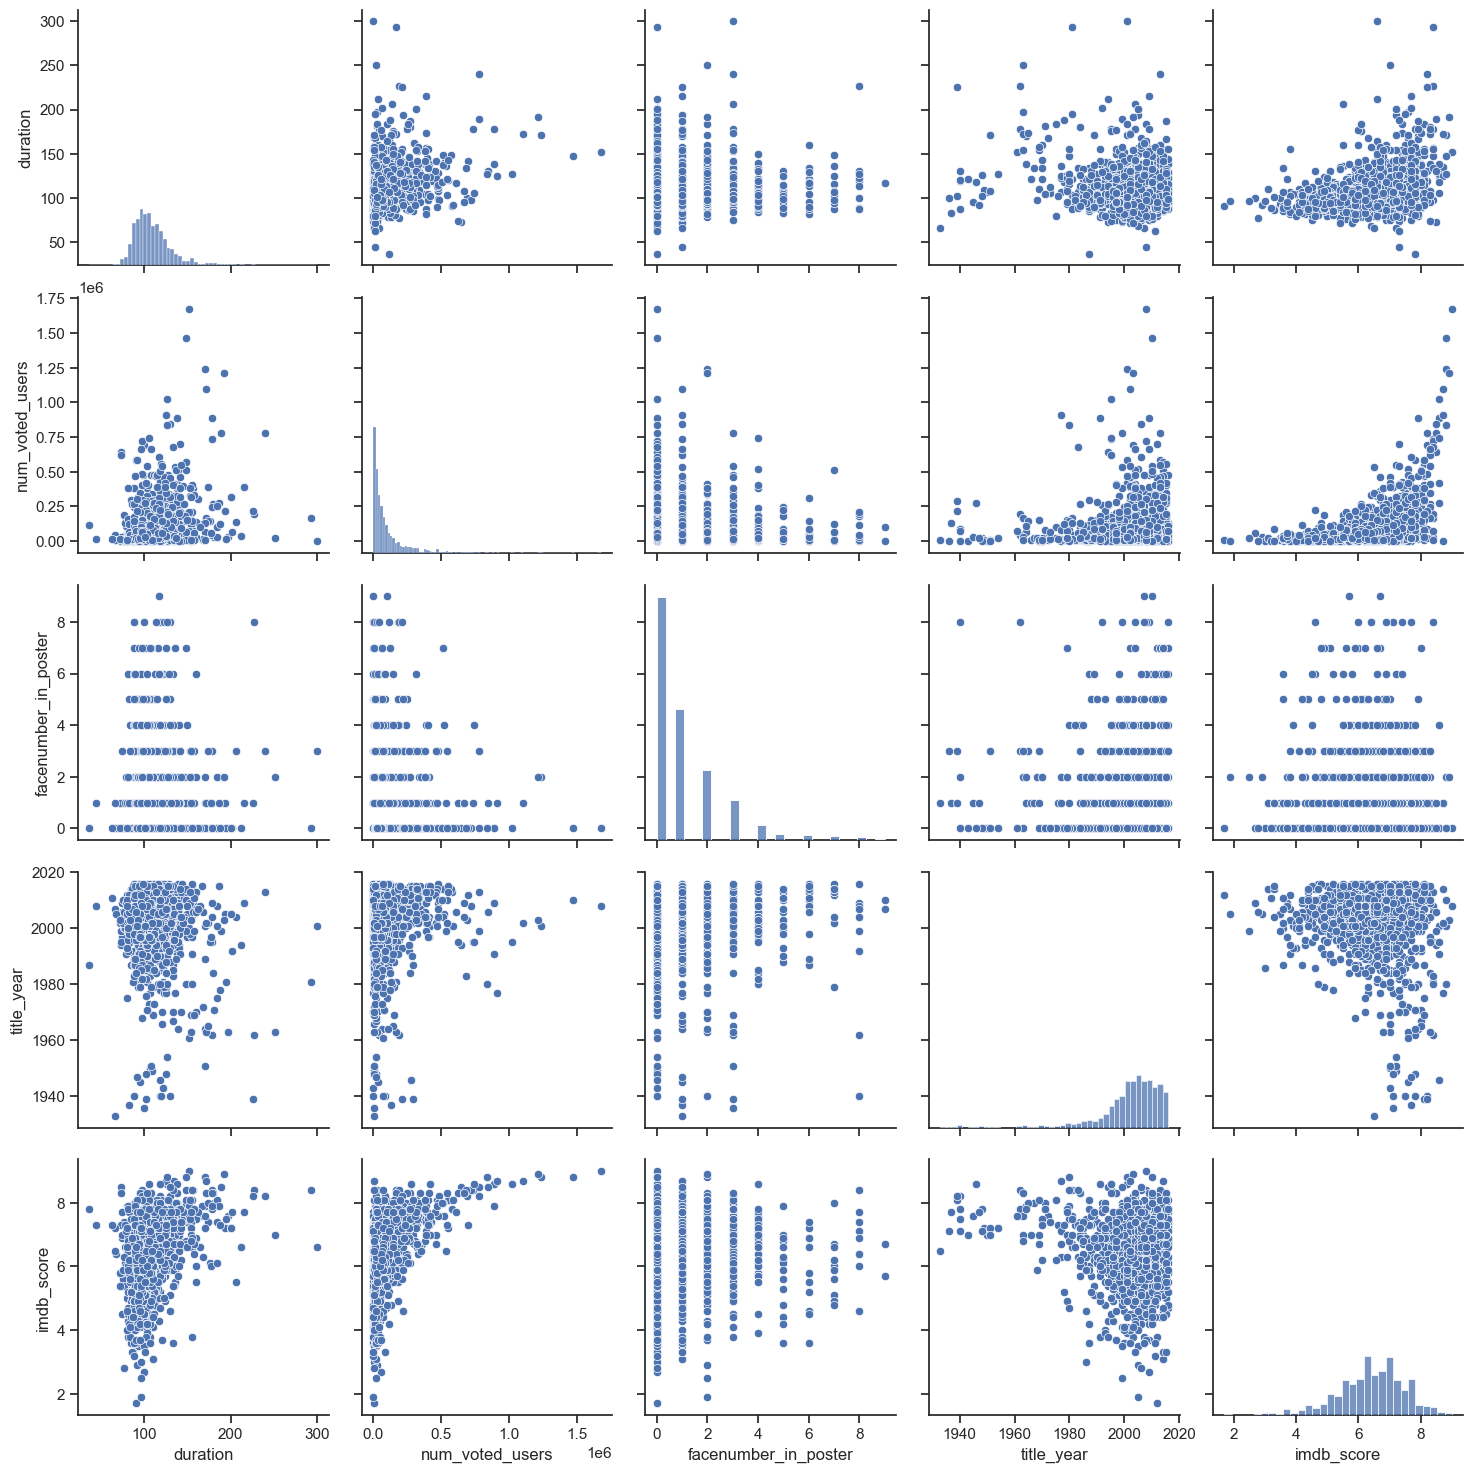

In [44]:
sns.pairplot(df, diag_kind='hist', height=3)

In [45]:
df = df[ ls_disc + ls_cont + [target] ]
df.head()

,n__genre_4,n__genre_1,n__genre_2,n__genre_3,n__language,n__country,n__content_rating,duration,num_voted_users,facenumber_in_poster,title_year,imdb_score
0,Thriller,Crime,Drama,Mystery,English,CAT_PEQUE,R,114.00,"28,584.00",1.00,"2,002.00",6.30
1,Thriller,Action,Horror,Mystery,English,USA,PG-13,113.00,"58,184.00",0.00,"1,999.00",4.90
2,Thriller,Action,Crime,Mystery,English,USA,R,101.00,"31,918.00",1.00,"2,009.00",5.50
3,Sci-Fi,Comedy,Drama,Romance,English,CAT_PEQUE,PG-13,90.00,"4,173.00",1.00,"2,010.00",6.10
4,Thriller,Action,Horror,Sci-Fi,English,USA,PG-13,109.00,"143,628.00",0.00,"2,004.00",5.60


## Modelado

### Preparación de sets

In [46]:
X = df.drop(columns=ls_disc)[ls_cont].join(pd.get_dummies(df[ls_disc], dtype='int'))
y = df[target]

print("Dimensiones del dataset: ", X.shape)

Dimensiones del dataset:  (1343, 42)


In [47]:
X.head()

,duration,num_voted_users,facenumber_in_poster,title_year,n__genre_4_CAT_PEQUE,n__genre_4_Family,n__genre_4_Fantasy,n__genre_4_Romance,n__genre_4_Sci-Fi,n__genre_4_Thriller,n__genre_1_Action,n__genre_1_Adventure,n__genre_1_Biography,n__genre_1_Comedy,n__genre_1_Crime,n__genre_1_Drama,n__genre_2_Adventure,n__genre_2_Animation,n__genre_2_CAT_PEQUE,n__genre_2_Comedy,n__genre_2_Crime,n__genre_2_Drama,n__genre_2_Horror,n__genre_3_CAT_PEQUE,n__genre_3_Comedy,n__genre_3_Crime,n__genre_3_Drama,n__genre_3_Family,n__genre_3_Fantasy,n__genre_3_Mystery,n__genre_3_Romance,n__genre_3_Sci-Fi,n__language_CAT_PEQUE,n__language_English,n__country_CAT_PEQUE,n__country_UK,n__country_USA,n__content_rating_CAT_PEQUE,n__content_rating_G,n__content_rating_PG,n__content_rating_PG-13,n__content_rating_R
0,114.00,"28,584.00",1.00,"2,002.00",0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1
1,113.00,"58,184.00",0.00,"1,999.00",0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
2,101.00,"31,918.00",1.00,"2,009.00",0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,90.00,"4,173.00",1.00,"2,010.00",0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0
4,109.00,"143,628.00",0.00,"2,004.00",0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0


In [48]:
y.head()

0   6.30
1   4.90
2   5.50
3   6.10
4   5.60
Name: imdb_score, dtype: float64

__SelectKBest__

SelectKBest removes all but the $k$ highest scoring features


In [49]:
kb = SelectKBest( k=5, score_func=f_regression )
kb.fit(X, y)

SelectKBest(k=5, score_func=<function f_regression at 0x16078e480>)

In [50]:
kb.get_feature_names_out()

array(['duration', 'num_voted_users', 'title_year', 'n__genre_1_Action',
       'n__genre_1_Biography'], dtype=object)

In [51]:
ls_best = [x for x, y in zip(X.columns, kb.get_support()) if y]
ls_best

['duration',
 'num_voted_users',
 'title_year',
 'n__genre_1_Action',
 'n__genre_1_Biography']

In [52]:
X = pd.DataFrame(kb.transform(X), columns=ls_best)
X

,duration,num_voted_users,title_year,n__genre_1_Action,n__genre_1_Biography
0,114.00,"28,584.00","2,002.00",0.00,0.00
1,113.00,"58,184.00","1,999.00",1.00,0.00
2,101.00,"31,918.00","2,009.00",1.00,0.00
3,90.00,"4,173.00","2,010.00",0.00,0.00
4,109.00,"143,628.00","2,004.00",1.00,0.00
...,...,...,...,...,...
1338,109.00,"5,971.00","2,002.00",0.00,0.00
1339,118.00,"227,072.00","2,010.00",1.00,0.00
1340,103.00,"48,999.00","2,008.00",1.00,0.00
1341,98.00,"67,653.00","2,008.00",0.00,0.00


__Conjunto de entrenamiento y validacion__

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [54]:
X_train

,duration,num_voted_users,title_year,n__genre_1_Action,n__genre_1_Biography
243,212.00,"35,314.00","1,994.00",0.00,0.00
6,90.00,"17,725.00","2,003.00",1.00,0.00
1134,110.00,"262,153.00","2,006.00",0.00,0.00
799,114.00,"53,132.00","1,996.00",1.00,0.00
404,118.00,"17,261.00","2,002.00",0.00,0.00
...,...,...,...,...,...
259,134.00,"19,026.00","1,967.00",0.00,1.00
253,89.00,"24,412.00","1,999.00",0.00,0.00
710,148.00,"30,434.00","2,013.00",1.00,0.00
625,103.00,"31,798.00","2,001.00",0.00,0.00


In [55]:
y_train

243    6.60
6      6.80
1134   7.80
799    5.80
404    6.60
       ... 
259    8.00
253    7.10
710    8.40
625    6.80
1192   4.20
Name: imdb_score, Length: 1007, dtype: float64

### Modelos

#### Regresión Lineal

In [56]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [57]:
linreg.score(X_train, y_train)

0.35754421138431713

In [58]:
ls_scores = cross_val_score(cv = 4, estimator=linreg, X=X_train, y=y_train)
ls_scores

array([0.36721616, 0.382622  , 0.26894521, 0.34763848])

In [59]:
print("MEAN", np.mean(ls_scores))
print("STD", np.std(ls_scores))

MEAN 0.3416054621140442
STD 0.04374406749176667


##### Evaluacion del modelo

In [60]:
# Make predictions.
y_pred = linreg.predict(X_test[X_train.columns])

# Calculate and print errors.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse:.4f}")

rmse = mse ** 0.5
print(f"Root mean squared error: {rmse:.4f}")

mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae:.4f}")

R-squared: 0.3046
Mean squared error: 0.7049
Root mean squared error: 0.8396
Mean Absolute Error: 0.6213


* __Relación entre predicciones y Valores Reales:__ idealmente, si el modelo fuera perfecto, todos los puntos se alinearían a lo largo de una linea diagonas $(y=x)$, lo que indicaría que las predicciones son exactamente iguales a los valores reales. _El modelo muestra una capacidad limitada para predecir con precisión, especialmente para los valores extremos._

Text(0, 0.5, 'Predicted Values')

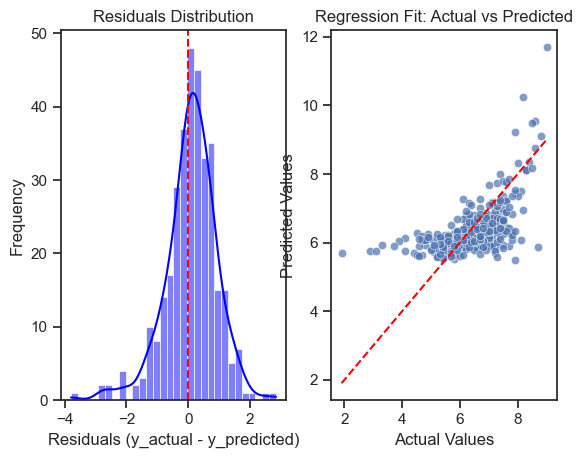

In [61]:
# Plot 1: Residuals Distribution.
plt.subplot(1,2,1)
residuals = y_test - linreg.predict(X_test)
sns.histplot(residuals, bins=30, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution")
plt.xlabel("Residuals (y_actual - y_predicted)")
plt.ylabel("Frequency")

# Plot 2: Regression Fit (Actual vs Predicted).
plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=linreg.predict(X_test), alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression Fit: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

* Un __MAE = 69.64__ significa que tu modelo tiene un error promedio de 69.64 unidades en sus predicciones.


In [62]:
"{:,.2%}".format(mean_absolute_error(y_pred=linreg.predict(X_test[X_train.columns]), y_true=y_test))

'62.13%'

__Intercepto y Coeficientes__

In [63]:
print("Intercepto: ", linreg.intercept_)
print("Coeficientes: ", linreg.coef_)
print("Columns: ", X_test.columns)

Intercepto:  34.789188258632045
Coeficientes:  [ 7.79458215e-03  3.35580362e-06 -1.47105276e-02 -3.61236710e-01
  5.75420448e-01]
Columns:  Index(['duration', 'num_voted_users', 'title_year', 'n__genre_1_Action',
       'n__genre_1_Biography'],
      dtype='object')


duration = 0.0077945822
num_voted_users = 3.3558e-06
title_year = -0.0147105276
n__genre_1_Action = -0.3612367102
n__genre_1_Biography = 0.5754204476
Intercept: 34.789188258632045

Feature Coefficients:
                 Feature  Coefficient
0              duration         0.01
1       num_voted_users         0.00
2            title_year        -0.01
3     n__genre_1_Action        -0.36
4  n__genre_1_Biography         0.58


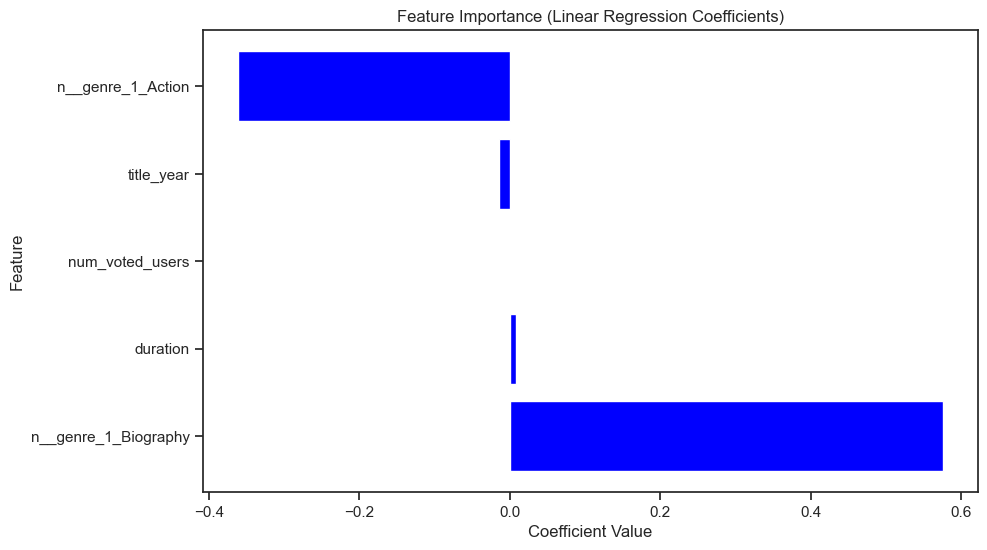

In [64]:
#print("Model coefficients:\n")
for i in range(X_test.shape[1]):
    print(X_test.columns[i], "=", linreg.coef_[i].round(10))

# Extraer información del modelo
print("Intercept:", linreg.intercept_)
coeff_df = pd.DataFrame({"Feature": X_test.columns, "Coefficient": linreg.coef_})
print("\nFeature Coefficients:\n", coeff_df)

# Resumir los resultados del modelo 
# Sort dataframe by coefficients.
coef_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

# Create plot.
plt.figure(figsize=(10,6))
#plt.barh(coeff_df["Feature"], coef_df_sorted["Coefficient"], color="blue")
plt.barh(data=coef_df_sorted, y="Feature", width="Coefficient", color="blue")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.show()

$$ \hat{y} = \beta_0 + \beta_i X_i $$

$$ \hat{y} = 5.341598 + 0.006384*duration + (3.037055e^{-06})*numvotedusers + 0.677938*colorBlackandWhite + 0.471207*genre1Biography + 0.322425*genre2Drama $$

* _duration_: es relativamente pequeño, lo que sugiere que la duración tiene un impacto modesto en la variable dependiente.
* _num_voted_users_: es muy pequeño, lo que indica que el numero de usuarios que votaron, tiene un impacto casi insignificante en la variable dependiente.
* _colorBlackandWhite_: es una variable categorica, por el valor del coeficiente significa que, en comparacion con el color, las peliculas en blanco y negro, tienen un valor de variable dependiente promedio de 0.67 unidades mayor.
* _genre1biography_: del mismo modo, tienen un valor de variable dependiente promedio 0.4712 unidades mayor al genero base.
* _genre2Drama_: del mismo modo, tienen un valor de variable dependiente promedio 0.3224 unidades mayor al genero base.


__Impacto Relativo__: Las variables categóricas (color, género) parecen tener un impacto mayor en la variable dependiente en comparación con las variables numéricas (duración, número de usuarios que votaron).

In [65]:
# Iterar sobre las filas de la muestra
for index, row in X_test.sample(5).iterrows():
    print(f"Index: {index}   y = {float(y_test.loc[[index]])}")
    # Intercepto
    y_hat=round(float(linreg.intercept_), 6)
    print(y_hat, end='')
    # Coeficientes
    for x,y in zip(linreg.coef_, row):
        y_hat += float(x)*float(y)
        print("+(", round(x, 6), "*", y, ")", end='')
    # valor de predicción
    print(" = ", round(y_hat, 6))


Index: 1255   y = 7.8
34.789188+( 0.007795 * 106.0 )+( 3e-06 * 106072.0 )+( -0.014711 * 2016.0 )+( -0.361237 * 0.0 )+( 0.57542 * 0.0 ) =  6.314947
Index: 1179   y = 7.9
34.789188+( 0.007795 * 178.0 )+( 3e-06 * 886204.0 )+( -0.014711 * 2009.0 )+( -0.361237 * 1.0 )+( 0.57542 * 0.0 ) =  9.235864
Index: 229   y = 6.7
34.789188+( 0.007795 * 103.0 )+( 3e-06 * 13874.0 )+( -0.014711 * 2010.0 )+( -0.361237 * 0.0 )+( 0.57542 * 0.0 ) =  6.070428
Index: 786   y = 6.7
34.789188+( 0.007795 * 110.0 )+( 3e-06 * 14618.0 )+( -0.014711 * 2002.0 )+( -0.361237 * 0.0 )+( 0.57542 * 0.0 ) =  6.245171
Index: 393   y = 4.8
34.789188+( 0.007795 * 91.0 )+( 3e-06 * 17722.0 )+( -0.014711 * 2004.0 )+( -0.361237 * 0.0 )+( 0.57542 * 0.0 ) =  6.078069


In [68]:
#X_test.loc[[459]]

#### Regresión Logistica

Determinar si la pelicula es buena o no

In [69]:
yc_train = (y_train > y_train.mean())*1
yc_test = (y_test > y_train.mean())*1

In [70]:
yc_train

243     1
6       1
1134    1
799     0
404     1
       ..
259     1
253     1
710     1
625     1
1192    0
Name: imdb_score, Length: 1007, dtype: int64

In [71]:
yc_test

442     1
371     1
1091    0
641     0
668     1
       ..
698     0
102     1
642     0
527     1
298     0
Name: imdb_score, Length: 336, dtype: int64

In [72]:
logreg = LogisticRegression()
logreg.fit(X_train, yc_train)

LogisticRegression()

In [73]:
logreg.score(X_test, yc_test)

0.7083333333333334

In [74]:
ls_scores = cross_val_score(cv=4, estimator=logreg, X=X_train, y=yc_train)

In [75]:
np.mean(ls_scores), np.std(ls_scores)

(np.float64(0.7149932017959906), np.float64(0.027703638276639922))

In [76]:
roc_auc_score(y_score=logreg.predict(X_test), y_true=yc_test)

np.float64(0.7122448979591838)

In [77]:
ls_best

['duration',
 'num_voted_users',
 'title_year',
 'n__genre_1_Action',
 'n__genre_1_Biography']

In [78]:
logreg.intercept_

array([0.054261])

In [79]:
logreg.coef_[0][0]

np.float64(0.020740010181292002)

In [80]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(yc_test, logreg.predict(X_test))
cnf_matrix

array([[103,  37],
       [ 61, 135]])

Text(0.5, 427.9555555555555, 'Predicted label')

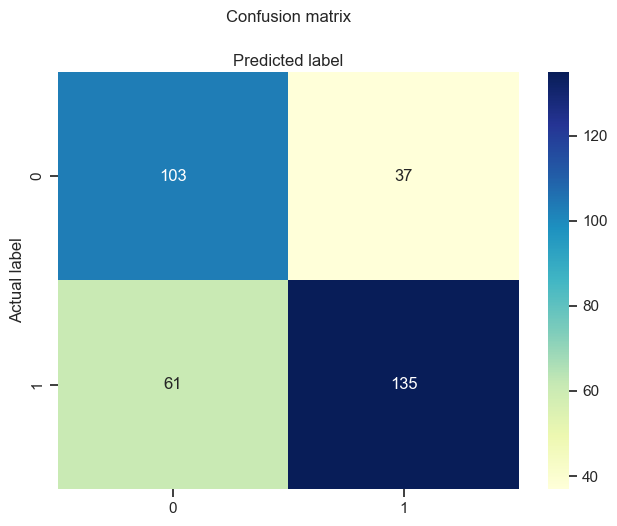

In [81]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [82]:
from sklearn.metrics import classification_report
target_names = ['without diabetes', 'with diabetes']
print(classification_report(yc_test, logreg.predict(X_test), target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.63      0.74      0.68       140
   with diabetes       0.78      0.69      0.73       196

        accuracy                           0.71       336
       macro avg       0.71      0.71      0.71       336
    weighted avg       0.72      0.71      0.71       336



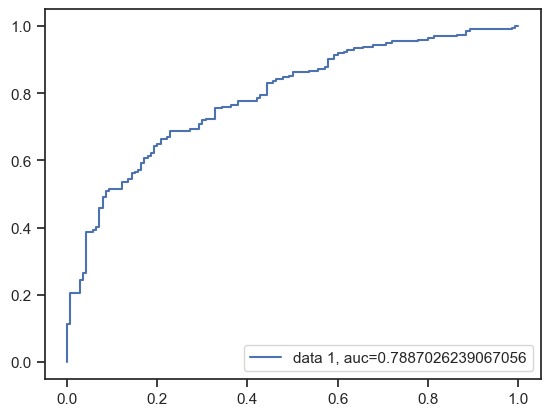

In [83]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(yc_test,  y_pred_proba)
auc = metrics.roc_auc_score(yc_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()